In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [111]:
train = pd.read_csv('trainMA.csv')
test = pd.read_csv('testMA.csv')


In [112]:
train = train.rename(columns={'Unnamed: 0': 'date_forecast'})
test = test.rename(columns={'Unnamed: 0': 'date_forecast'})

In [113]:
train.set_index('date_forecast', inplace=True)
test.set_index('date_forecast', inplace=True)
train.index = pd.to_datetime(train.index)
#test = test.drop(columns = ['date_calc'])

In [114]:
columns_only_in_df2 = train.columns.difference(test.columns)

# Visualizza le colonne uniche in ciascun DataFrame
print("Colonne presenti solo in df1:")
print(columns_only_in_df2)

Colonne presenti solo in df1:
Index(['pv_measurement'], dtype='object')


In [115]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train['is_est'] = 0
train['is_est'].iloc[-4418:] = 1


C:\Users\claxl\AppData\Local\Temp\ipykernel_88312\2428353307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_est'].iloc[-4418:] = 1


<Axes: ylabel='Frequency'>

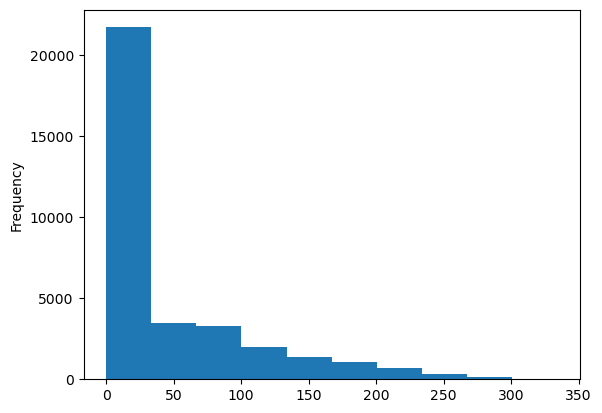

In [116]:
train['diffuse_radW'].plot.hist()


<Axes: xlabel='date_forecast'>

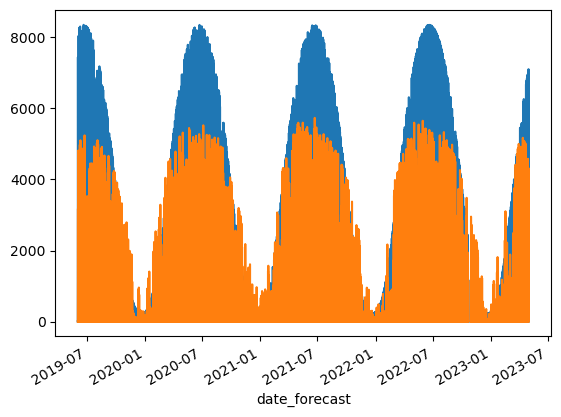

In [117]:
((train['clear_sky_radW']*train['total_cloud_coverp'])/10).plot()
(train['pv_measurement']).plot()


In [118]:
train['total_cloud_coverp'].describe()

count    34062.000000
mean        74.359434
std         33.500200
min          0.000000
25%         54.600000
50%         93.649998
75%         99.950001
max        100.000000
Name: total_cloud_coverp, dtype: float64

In [119]:
nan_col = ['snow_densitykgm3','ceiling_height_aglm','cloud_base_aglm']
test['snow_densitykgm3'].fillna(0)
for col in nan_col:
    
    test[col] = test[col].fillna(0)
    train[col] = train[col].fillna(train[col].median())

train=train.dropna()
test=test.dropna()

In [120]:
train.columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'minute', 'hour', 

In [121]:
train.shape, test.shape

((34061, 50), (720, 48))

In [122]:
train['pv_measurement'] = train['pv_measurement'].mask(train['is_in_shadowidx'] == 1, 0)


<Axes: xlabel='date_forecast'>

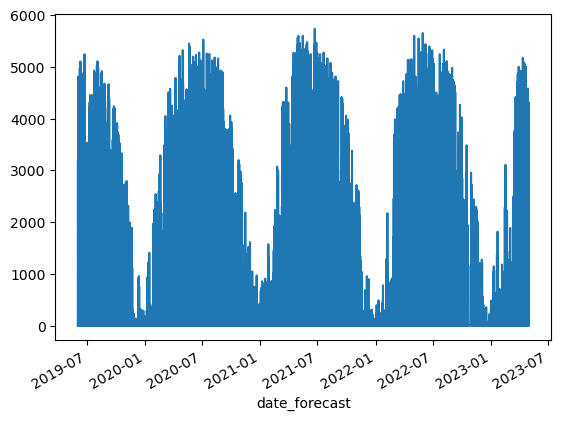

In [123]:
train['pv_measurement'].plot()

In [124]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [125]:
def outlier_detect_ZScore(data, col, threshold=3):
    '''
    Outlier detection by Z-Score method. 
    Calculate the Z-score for each data point.
    Any value beyond:
        upper bound = mean + (Z-score * threshold * standard deviation)
        lower bound = mean - (Z-score * threshold * standard deviation)   
    are regarded as outliers. Default threshold is 3.
    
    Parameters:
    - data: The pandas DataFrame containing the data.
    - col: The name of the column in the DataFrame to perform outlier detection on.
    - threshold: The Z-score threshold for defining outliers. Default is 3.
    
    Returns:
    - outlier_index: A boolean Series indicating which rows are outliers.
    - para: Tuple containing the upper and lower bounds for outliers.
    '''
    mean = data[col].mean()
    std = data[col].std()
    Upper_fence = mean + (threshold * std)
    Lower_fence = mean - (threshold * std)
    para = (Lower_fence, Upper_fence)
    z_scores = (data[col] - mean) / std
    outlier_index = (z_scores > threshold) | (z_scores < -threshold)
    if outlier_index.any():
        num_outliers = outlier_index.value_counts()[True]
        print(f'Num of outliers detected: {num_outliers} in column {col}')
        percentage_of_outliers = (num_outliers / len(data)) * 100
        print(f'Percentage of outliers: {percentage_of_outliers:.2f}% relative to {len(data)} data points')
        print('————————————————————————————————————————————————————')
    return outlier_index, para
def remove_outliers_ZScore(data, col, threshold=3):
    outlier_index, _ = outlier_detect_ZScore(data, col, threshold)
    data_cleaned = data[~outlier_index]
    return data_cleaned

In [126]:
for col in train.columns:
    data_without_outliers = remove_outliers_ZScore(train, col, threshold=3)


Num of outliers detected: 92 in column absolute_humidity_2mgm3
Percentage of outliers: 0.27% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 262 in column air_density_2mkgm3
Percentage of outliers: 0.77% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 552 in column ceiling_height_aglm
Percentage of outliers: 1.62% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 1019 in column cloud_base_aglm
Percentage of outliers: 2.99% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 1210 in column dew_or_rimeidx
Percentage of outliers: 3.55% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 69 in column dew_point_2mK
Percentage of outliers: 0.20% relative to 34061 data points
———————————————————————————

In [127]:
train['hours'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear

In [128]:
test['hours'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear

In [129]:
# Supponiamo che "gruppi" sia il risultato della suddivisione
gruppi = train.groupby('is_est')

# Itera attraverso i gruppi e crea un DataFrame separato per ciascun gruppo
dataframes_per_gruppo = {}
for valore, gruppo in gruppi:
    dataframes_per_gruppo[valore] = gruppo.copy()
train_set = dataframes_per_gruppo[0]
val_set = dataframes_per_gruppo[1]

In [130]:
train_set = train_set.drop(columns = ['is_est'])
val_set = val_set.drop(columns = ['is_est'])

In [131]:
train = train.drop(columns = ['is_est'])

In [132]:
from sklearn.model_selection import TimeSeriesSplit
data = train

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits =2


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [133]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [134]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

[I 2023-11-01 22:29:47,420] A new study created in memory with name: no-name-86e6cba5-deef-4bc7-813f-565dc485c4ae


In [149]:
study.optimize(objective, n_trials=50)

Mean Absolute Error: 605.4917896934614


[I 2023-11-01 22:30:12,397] Trial 0 finished with value: 593.0051376680426 and parameters: {'n_estimators': 513, 'reg_alpha': 0.014261547501590624, 'reg_lambda': 6.634246938079214, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0008541063710618212, 'max_depth': 5, 'num_leaves': 264, 'min_child_samples': 175, 'min_data_per_groups': 100}. Best is trial 0 with value: 593.0051376680426.


Mean Absolute Error: 580.5184856426237
Mean Absolute Error: 192.48575634070727


[I 2023-11-01 22:30:18,629] Trial 1 finished with value: 189.09715629770886 and parameters: {'n_estimators': 961, 'reg_alpha': 0.5994069174162646, 'reg_lambda': 5.2643707880969695, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.018209205908128908, 'max_depth': 11, 'num_leaves': 188, 'min_child_samples': 76, 'min_data_per_groups': 32}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 185.70855625471043
Mean Absolute Error: 699.9205359939405


[I 2023-11-01 22:30:21,655] Trial 2 finished with value: 684.2807514206042 and parameters: {'n_estimators': 731, 'reg_alpha': 0.057422997549145156, 'reg_lambda': 0.03826219894463125, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.00034257387374713496, 'max_depth': 36, 'num_leaves': 488, 'min_child_samples': 290, 'min_data_per_groups': 41}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 668.640966847268
Mean Absolute Error: 189.34161477448336


[I 2023-11-01 22:30:26,181] Trial 3 finished with value: 189.39328531151335 and parameters: {'n_estimators': 642, 'reg_alpha': 0.2083352873127728, 'reg_lambda': 2.757739223303751, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01680779802215205, 'max_depth': 30, 'num_leaves': 736, 'min_child_samples': 224, 'min_data_per_groups': 85}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 189.44495584854337
Mean Absolute Error: 230.01881438944133


[I 2023-11-01 22:30:31,574] Trial 4 finished with value: 229.82713170382294 and parameters: {'n_estimators': 701, 'reg_alpha': 0.004815160123960318, 'reg_lambda': 0.0030633943619962772, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0037015738119064215, 'max_depth': 45, 'num_leaves': 571, 'min_child_samples': 186, 'min_data_per_groups': 73}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 229.63544901820458
Mean Absolute Error: 671.7002967553894


[I 2023-11-01 22:30:37,372] Trial 5 finished with value: 656.2349514017175 and parameters: {'n_estimators': 903, 'reg_alpha': 1.4997610484031885, 'reg_lambda': 0.05472955841917235, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.000331412215605866, 'max_depth': 25, 'num_leaves': 699, 'min_child_samples': 180, 'min_data_per_groups': 4}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 640.7696060480455
Mean Absolute Error: 681.683415897171


[I 2023-11-01 22:30:45,603] Trial 6 finished with value: 665.8129530818942 and parameters: {'n_estimators': 762, 'reg_alpha': 2.3535331161781996, 'reg_lambda': 0.002661423320807092, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.0003623130467425068, 'max_depth': 47, 'num_leaves': 911, 'min_child_samples': 59, 'min_data_per_groups': 6}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 649.9424902666173
Mean Absolute Error: 783.1478970412255


[I 2023-11-01 22:30:47,608] Trial 7 finished with value: 765.7223704679066 and parameters: {'n_estimators': 176, 'reg_alpha': 0.0029000525475201488, 'reg_lambda': 0.49819548573178474, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0006244752405581189, 'max_depth': 29, 'num_leaves': 633, 'min_child_samples': 90, 'min_data_per_groups': 43}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 748.2968438945875
Mean Absolute Error: 317.5073573251775


[I 2023-11-01 22:31:16,732] Trial 8 finished with value: 311.36527961687113 and parameters: {'n_estimators': 956, 'reg_alpha': 0.06982073075686523, 'reg_lambda': 0.008266878159812066, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0015843282860977012, 'max_depth': 22, 'num_leaves': 216, 'min_child_samples': 11, 'min_data_per_groups': 57}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 305.22320190856476
Mean Absolute Error: 193.85294213161222


[I 2023-11-01 22:31:33,162] Trial 9 finished with value: 192.32622408267042 and parameters: {'n_estimators': 949, 'reg_alpha': 0.0015716187179419213, 'reg_lambda': 0.10861109095472124, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.004683176859995181, 'max_depth': 10, 'num_leaves': 379, 'min_child_samples': 30, 'min_data_per_groups': 1}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 190.79950603372865
Mean Absolute Error: 199.09095108405145


[I 2023-11-01 22:31:34,481] Trial 10 finished with value: 197.76781517820768 and parameters: {'n_estimators': 211, 'reg_alpha': 6.151742031205379, 'reg_lambda': 9.86713177318256, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.09980901195989857, 'max_depth': 14, 'num_leaves': 6, 'min_child_samples': 107, 'min_data_per_groups': 27}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 196.44467927236389
Mean Absolute Error: 192.15922860687095


[I 2023-11-01 22:31:39,071] Trial 11 finished with value: 191.50353131944092 and parameters: {'n_estimators': 478, 'reg_alpha': 0.4938804096109995, 'reg_lambda': 1.8243574711874528, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017548736822937974, 'max_depth': 17, 'num_leaves': 845, 'min_child_samples': 240, 'min_data_per_groups': 90}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 190.8478340320109
Mean Absolute Error: 190.18177842773713


[I 2023-11-01 22:31:41,855] Trial 12 finished with value: 190.28651900554433 and parameters: {'n_estimators': 462, 'reg_alpha': 0.3095492887421217, 'reg_lambda': 1.4943627070818535, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.015100159766689544, 'max_depth': 34, 'num_leaves': 45, 'min_child_samples': 237, 'min_data_per_groups': 67}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 190.39125958335154
Mean Absolute Error: 206.57718172867789


[I 2023-11-01 22:31:43,267] Trial 13 finished with value: 211.74725495487633 and parameters: {'n_estimators': 607, 'reg_alpha': 0.27462339119619317, 'reg_lambda': 2.4353290623216552, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.016798112555239685, 'max_depth': 2, 'num_leaves': 742, 'min_child_samples': 134, 'min_data_per_groups': 29}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 216.91732818107474
Mean Absolute Error: 825.8879750252901


[I 2023-11-01 22:31:45,425] Trial 14 finished with value: 808.3479494117994 and parameters: {'n_estimators': 338, 'reg_alpha': 0.12627343423241244, 'reg_lambda': 0.34532197394749775, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.00014327778021107858, 'max_depth': 36, 'num_leaves': 987, 'min_child_samples': 230, 'min_data_per_groups': 83}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 790.8079237983088
Mean Absolute Error: 201.09545577523355


[I 2023-11-01 22:31:51,669] Trial 15 finished with value: 199.3499193922912 and parameters: {'n_estimators': 822, 'reg_alpha': 0.9723647772286841, 'reg_lambda': 9.564867306916277, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.05915572598421267, 'max_depth': 20, 'num_leaves': 449, 'min_child_samples': 295, 'min_data_per_groups': 27}. Best is trial 1 with value: 189.09715629770886.


Mean Absolute Error: 197.60438300934885
Mean Absolute Error: 187.55061330178486


[I 2023-11-01 22:31:59,242] Trial 16 finished with value: 186.96988504075125 and parameters: {'n_estimators': 654, 'reg_alpha': 7.927339820500572, 'reg_lambda': 0.7656743235771799, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008598288124165188, 'max_depth': 29, 'num_leaves': 203, 'min_child_samples': 66, 'min_data_per_groups': 61}. Best is trial 16 with value: 186.96988504075125.


Mean Absolute Error: 186.38915677971764
Mean Absolute Error: 780.6765651987818


[I 2023-11-01 22:31:59,668] Trial 17 finished with value: 763.6167765769541 and parameters: {'n_estimators': 18, 'reg_alpha': 7.380140225392332, 'reg_lambda': 0.635234929141581, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.006270508318932094, 'max_depth': 10, 'num_leaves': 156, 'min_child_samples': 64, 'min_data_per_groups': 53}. Best is trial 16 with value: 186.96988504075125.


Mean Absolute Error: 746.5569879551264
Mean Absolute Error: 186.62177184829167


[I 2023-11-01 22:32:08,573] Trial 18 finished with value: 186.6224521525578 and parameters: {'n_estimators': 835, 'reg_alpha': 9.84750727194758, 'reg_lambda': 0.22231156773144647, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.007205272018868659, 'max_depth': 41, 'num_leaves': 327, 'min_child_samples': 110, 'min_data_per_groups': 18}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 186.62313245682392
Mean Absolute Error: 336.10785336258624


[I 2023-11-01 22:32:16,046] Trial 19 finished with value: 331.3227772845537 and parameters: {'n_estimators': 851, 'reg_alpha': 3.7752013304714875, 'reg_lambda': 0.17340500783652552, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0016308551799082286, 'max_depth': 42, 'num_leaves': 336, 'min_child_samples': 128, 'min_data_per_groups': 15}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 326.5377012065212
Mean Absolute Error: 189.49026126017748


[I 2023-11-01 22:32:22,753] Trial 20 finished with value: 190.1621220578122 and parameters: {'n_estimators': 583, 'reg_alpha': 9.18675343650953, 'reg_lambda': 0.16723645751543748, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.007916501009903874, 'max_depth': 40, 'num_leaves': 126, 'min_child_samples': 34, 'min_data_per_groups': 68}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 190.83398285544698
Mean Absolute Error: 189.14251167794004


[I 2023-11-01 22:32:32,680] Trial 21 finished with value: 187.49682436215136 and parameters: {'n_estimators': 992, 'reg_alpha': 3.645157283396601, 'reg_lambda': 0.7508959667444988, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.010012338226093778, 'max_depth': 29, 'num_leaves': 339, 'min_child_samples': 84, 'min_data_per_groups': 17}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 185.85113704636268
Mean Absolute Error: 187.14192322347785


[I 2023-11-01 22:32:41,779] Trial 22 finished with value: 186.6550544399388 and parameters: {'n_estimators': 832, 'reg_alpha': 2.995194332443681, 'reg_lambda': 0.8247237102272363, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008366838207794856, 'max_depth': 50, 'num_leaves': 343, 'min_child_samples': 113, 'min_data_per_groups': 19}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 186.16818565639971
Mean Absolute Error: 213.70449483918298


[I 2023-11-01 22:32:48,754] Trial 23 finished with value: 213.47256742328142 and parameters: {'n_estimators': 777, 'reg_alpha': 9.989676159870903, 'reg_lambda': 0.8924235039699713, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0038152536951146297, 'max_depth': 50, 'num_leaves': 277, 'min_child_samples': 113, 'min_data_per_groups': 18}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 213.24064000737982
Mean Absolute Error: 258.90834009403346


[I 2023-11-01 22:32:56,170] Trial 24 finished with value: 257.6771379165486 and parameters: {'n_estimators': 856, 'reg_alpha': 2.0131706336652635, 'reg_lambda': 0.3395677175676668, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.002437193166337082, 'max_depth': 50, 'num_leaves': 380, 'min_child_samples': 156, 'min_data_per_groups': 43}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 256.4459357390637
Mean Absolute Error: 188.82127727261215


[I 2023-11-01 22:33:04,571] Trial 25 finished with value: 188.31531061259267 and parameters: {'n_estimators': 685, 'reg_alpha': 4.943145740628502, 'reg_lambda': 1.1677821182563977, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.008357737687245778, 'max_depth': 41, 'num_leaves': 90, 'min_child_samples': 103, 'min_data_per_groups': 11}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 187.80934395257322
Mean Absolute Error: 194.05298966592838


[I 2023-11-01 22:33:13,308] Trial 26 finished with value: 191.83811873374685 and parameters: {'n_estimators': 550, 'reg_alpha': 1.2164833706146496, 'reg_lambda': 0.34396792186751207, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.03398236180628897, 'max_depth': 45, 'num_leaves': 438, 'min_child_samples': 51, 'min_data_per_groups': 60}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 189.6232478015653
Mean Absolute Error: 195.28759088308655


[I 2023-11-01 22:33:45,081] Trial 27 finished with value: 195.4551796371906 and parameters: {'n_estimators': 776, 'reg_alpha': 3.168584081530626, 'reg_lambda': 3.193187483435945, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.005742722890747057, 'max_depth': 33, 'num_leaves': 262, 'min_child_samples': 1, 'min_data_per_groups': 35}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 195.6227683912947
Mean Absolute Error: 190.1239174821646


[I 2023-11-01 22:33:49,400] Trial 28 finished with value: 189.05297102784084 and parameters: {'n_estimators': 394, 'reg_alpha': 2.4038120843251045, 'reg_lambda': 1.1754360576414575, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02874309950968634, 'max_depth': 39, 'num_leaves': 504, 'min_child_samples': 148, 'min_data_per_groups': 21}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 187.9820245735171
Mean Absolute Error: 187.37773273299973


[I 2023-11-01 22:33:54,689] Trial 29 finished with value: 187.70832993575493 and parameters: {'n_estimators': 674, 'reg_alpha': 9.973075491362978, 'reg_lambda': 4.131212413919501, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.009314002815513537, 'max_depth': 46, 'num_leaves': 265, 'min_child_samples': 197, 'min_data_per_groups': 49}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 188.0389271385101
Mean Absolute Error: 241.0906437196845


[I 2023-11-01 22:34:01,433] Trial 30 finished with value: 240.93192610605533 and parameters: {'n_estimators': 874, 'reg_alpha': 1.0132476723455244, 'reg_lambda': 0.22386024439954114, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.002680324652891582, 'max_depth': 25, 'num_leaves': 554, 'min_child_samples': 156, 'min_data_per_groups': 100}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 240.77320849242616
Mean Absolute Error: 189.0200969608401


[I 2023-11-01 22:34:11,503] Trial 31 finished with value: 187.13964678841018 and parameters: {'n_estimators': 908, 'reg_alpha': 4.048760005631834, 'reg_lambda': 0.7106585528893934, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.010648496956915597, 'max_depth': 29, 'num_leaves': 320, 'min_child_samples': 85, 'min_data_per_groups': 11}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 185.25919661598027
Mean Absolute Error: 189.65535181312202


[I 2023-11-01 22:34:23,301] Trial 32 finished with value: 187.64620003986255 and parameters: {'n_estimators': 914, 'reg_alpha': 4.9478355971028956, 'reg_lambda': 0.5737198474377139, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.011652041730046124, 'max_depth': 37, 'num_leaves': 202, 'min_child_samples': 75, 'min_data_per_groups': 11}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 185.63704826660307
Mean Absolute Error: 189.18523213635996


[I 2023-11-01 22:34:30,671] Trial 33 finished with value: 189.8729435232692 and parameters: {'n_estimators': 807, 'reg_alpha': 4.748434437565014, 'reg_lambda': 1.4557744005993372, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0057113479085218665, 'max_depth': 32, 'num_leaves': 342, 'min_child_samples': 124, 'min_data_per_groups': 38}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 190.56065491017844
Mean Absolute Error: 193.339183234007


[I 2023-11-01 22:34:38,609] Trial 34 finished with value: 191.62333922512266 and parameters: {'n_estimators': 742, 'reg_alpha': 1.8728370081101084, 'reg_lambda': 0.7886026790413508, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.026732908220180183, 'max_depth': 27, 'num_leaves': 287, 'min_child_samples': 95, 'min_data_per_groups': 11}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 189.90749521623835
Mean Absolute Error: 190.50446367587404


[I 2023-11-01 22:34:46,714] Trial 35 finished with value: 190.98444209231323 and parameters: {'n_estimators': 638, 'reg_alpha': 0.71141648584855, 'reg_lambda': 3.8847326430297766, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.006897094686862866, 'max_depth': 22, 'num_leaves': 414, 'min_child_samples': 41, 'min_data_per_groups': 24}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 191.46442050875243
Mean Absolute Error: 190.4281513879144


[I 2023-11-01 22:35:02,147] Trial 36 finished with value: 188.26112967711205 and parameters: {'n_estimators': 998, 'reg_alpha': 3.08428975133487, 'reg_lambda': 0.07645492375134673, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01029990734383624, 'max_depth': 44, 'num_leaves': 211, 'min_child_samples': 75, 'min_data_per_groups': 32}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 186.0941079663097
Mean Absolute Error: 214.04318867943329


[I 2023-11-01 22:35:09,721] Trial 37 finished with value: 213.76176148065542 and parameters: {'n_estimators': 733, 'reg_alpha': 6.457230777927356, 'reg_lambda': 2.18272603689881, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.004127676316663781, 'max_depth': 38, 'num_leaves': 510, 'min_child_samples': 137, 'min_data_per_groups': 8}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 213.4803342818776
Mean Absolute Error: 192.4657303899252


[I 2023-11-01 22:35:23,018] Trial 38 finished with value: 190.97533153777488 and parameters: {'n_estimators': 912, 'reg_alpha': 1.4836356565063715, 'reg_lambda': 0.03371063867396989, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.011503383712463787, 'max_depth': 48, 'num_leaves': 108, 'min_child_samples': 116, 'min_data_per_groups': 76}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 189.48493268562456
Mean Absolute Error: 194.80192460242603


[I 2023-11-01 22:35:35,862] Trial 39 finished with value: 192.05315304329545 and parameters: {'n_estimators': 813, 'reg_alpha': 2.626021196042036, 'reg_lambda': 5.608292163154201, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.022455382143469302, 'max_depth': 31, 'num_leaves': 165, 'min_child_samples': 68, 'min_data_per_groups': 21}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 189.30438148416488
Mean Absolute Error: 188.93214630198676


[I 2023-11-01 22:35:44,889] Trial 40 finished with value: 188.31219077164187 and parameters: {'n_estimators': 709, 'reg_alpha': 0.02154709878491507, 'reg_lambda': 0.46370325041276844, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.013307792075404, 'max_depth': 43, 'num_leaves': 313, 'min_child_samples': 169, 'min_data_per_groups': 46}. Best is trial 18 with value: 186.6224521525578.


Mean Absolute Error: 187.69223524129697
Mean Absolute Error: 187.7316253058048


[I 2023-11-01 22:35:55,177] Trial 41 finished with value: 186.60034427252805 and parameters: {'n_estimators': 1000, 'reg_alpha': 3.862502736156007, 'reg_lambda': 0.8587697228662562, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008487340360537705, 'max_depth': 28, 'num_leaves': 232, 'min_child_samples': 86, 'min_data_per_groups': 15}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 185.4690632392513
Mean Absolute Error: 188.062268152083


[I 2023-11-01 22:36:03,545] Trial 42 finished with value: 188.19825111738538 and parameters: {'n_estimators': 932, 'reg_alpha': 5.381977757391679, 'reg_lambda': 0.7844450909264095, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.005361009087361667, 'max_depth': 27, 'num_leaves': 235, 'min_child_samples': 92, 'min_data_per_groups': 6}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 188.33423408268777
Mean Absolute Error: 188.66530085683604


[I 2023-11-01 22:36:17,637] Trial 43 finished with value: 186.71809887151613 and parameters: {'n_estimators': 960, 'reg_alpha': 7.1920091707217235, 'reg_lambda': 1.0945074025664763, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008014418281000036, 'max_depth': 35, 'num_leaves': 383, 'min_child_samples': 50, 'min_data_per_groups': 3}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 184.7708968861962
Mean Absolute Error: 200.59060330488035


[I 2023-11-01 22:36:32,382] Trial 44 finished with value: 199.69914690698005 and parameters: {'n_estimators': 969, 'reg_alpha': 7.84094485023775, 'reg_lambda': 1.3980861846536992, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0036266684161627076, 'max_depth': 35, 'num_leaves': 422, 'min_child_samples': 49, 'min_data_per_groups': 2}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 198.80769050907978
Mean Absolute Error: 192.94527285055588


[I 2023-11-01 22:36:56,293] Trial 45 finished with value: 190.0118227273681 and parameters: {'n_estimators': 957, 'reg_alpha': 1.6317395369322383, 'reg_lambda': 2.4770555437592208, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.007402172449598728, 'max_depth': 23, 'num_leaves': 378, 'min_child_samples': 20, 'min_data_per_groups': 16}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 187.07837260418034
Mean Absolute Error: 191.45967490001962


[I 2023-11-01 22:37:06,679] Trial 46 finished with value: 189.3145312650718 and parameters: {'n_estimators': 838, 'reg_alpha': 5.664842977823518, 'reg_lambda': 0.4701009839391392, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01547867288996691, 'max_depth': 34, 'num_leaves': 628, 'min_child_samples': 58, 'min_data_per_groups': 59}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 187.16938763012396
Mean Absolute Error: 196.4028109005894


[I 2023-11-01 22:37:13,006] Trial 47 finished with value: 196.9109309185692 and parameters: {'n_estimators': 873, 'reg_alpha': 2.721604612468482, 'reg_lambda': 1.7679994259676077, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.00482819480708515, 'max_depth': 18, 'num_leaves': 44, 'min_child_samples': 25, 'min_data_per_groups': 1}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 197.419050936549
Mean Absolute Error: 189.9165274935015


[I 2023-11-01 22:37:21,867] Trial 48 finished with value: 188.40848641093095 and parameters: {'n_estimators': 890, 'reg_alpha': 6.717136093514069, 'reg_lambda': 0.9366022211037761, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.018754430168774695, 'max_depth': 26, 'num_leaves': 479, 'min_child_samples': 100, 'min_data_per_groups': 22}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 186.90044532836038
Mean Absolute Error: 241.11950469824367


[I 2023-11-01 22:37:26,419] Trial 49 finished with value: 242.22886625129473 and parameters: {'n_estimators': 785, 'reg_alpha': 0.5554868018561598, 'reg_lambda': 0.27299233841565823, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.00304167135063434, 'max_depth': 48, 'num_leaves': 240, 'min_child_samples': 269, 'min_data_per_groups': 65}. Best is trial 41 with value: 186.60034427252805.


Mean Absolute Error: 243.3382278043458


In [150]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 186.60034427252805
{'n_estimators': 1000, 'reg_alpha': 3.862502736156007, 'reg_lambda': 0.8587697228662562, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008487340360537705, 'max_depth': 28, 'num_leaves': 232, 'min_child_samples': 86, 'min_data_per_groups': 15}


In [151]:
param = {'n_estimators': 352, 'reg_alpha': 0.003142082634552811, 'reg_lambda': 0.02020074558999535, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.026901602727684413, 'max_depth': 13, 'num_leaves': 192, 'min_child_samples': 57, 'min_data_per_groups': 28}

In [155]:
model_A = lgb.LGBMRegressor(**trial.params)

In [156]:
X_train = train.drop(columns = 'pv_measurement')
y_train = train['pv_measurement']

In [157]:
pd.set_option('display.max_columns', 184)

test.shape,train.shape

((720, 69), (34061, 70))

In [158]:
model_A.fit(X_train,y_train)
y_pred_A = model_A.predict(test)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12150
[LightGBM] [Info] Number of data points in the train set: 34061, number of used features: 64
[LightGBM] [Info] Start training from score 629.398666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

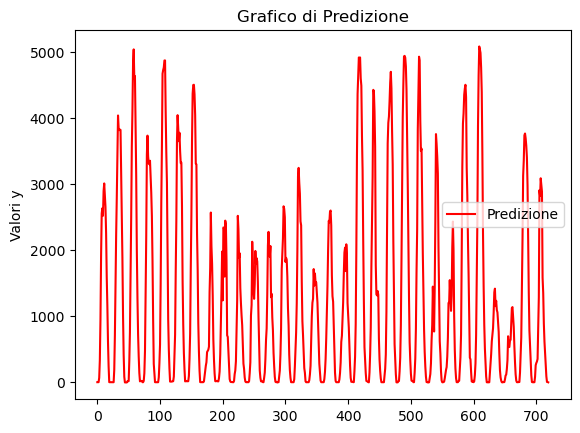

In [91]:
plt.plot(range(len(y_pred_A)), (y_pred_A), label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [117]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [118]:
test = test.reset_index()
df.loc[test['is_in_shadowidx'] == 1, 'Prediction'] = 0


In [119]:
df.to_csv('A5.csv')

In [120]:
df

,Prediction
0,0.000000
1,0.000000
2,0.000000
3,49.317985
4,280.625220
...,...
715,307.166398
716,79.626692
717,0.000000
718,0.000000


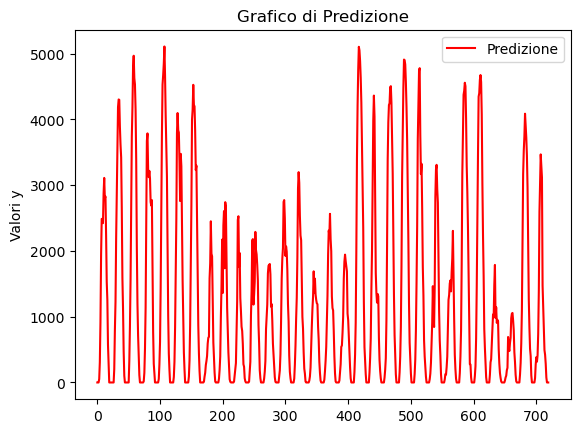

In [416]:
plt.plot(range(len(y_pred_A)), (df['Prediction']), label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [135]:
train['Radiazione_solare_effettiva'] = (train['direct_radW']) + (train['effective_cloud_coverp'])

test['Radiazione_solare_effettiva'] = (test['direct_radW'] ) + (test['effective_cloud_coverp'])
train['Radiazione_solare_effettiva'] = (train['direct_rad_1hJ']) + (train['effective_cloud_coverp'])

test['Radiazione_solare_effettiva'] = (test['direct_rad_1hJ'] ) + (test['effective_cloud_coverp'])

In [136]:
train['radmul'] = (train['direct_radW'] + train['diffuse_radW']) * (1 - train['effective_cloud_coverp'])/100
test['radmul'] = (test['direct_radW'] + test['diffuse_radW']) * (1 - test['effective_cloud_coverp'])/100

In [137]:
train['raddir'] = (train['direct_radW'] ) * (train['absolute_humidity_2mgm3'])
test['raddir'] = (test['direct_radW'] ) * (test['absolute_humidity_2mgm3'])

In [138]:
train['wind3'] = train['wind_speed_10mms'] * train['cloud_base_aglm']
test['wind3'] = test['wind_speed_10mms'] * test['cloud_base_aglm']

In [139]:
train['winddif'] = train['wind_speed_10mms'] * train['diffuse_radW']
test['winddif'] = test['wind_speed_10mms'] * test['diffuse_radW']

In [140]:
train['winddir'] = train['wind_speed_10mms'] * train['direct_radW']
test['winddir'] = test['wind_speed_10mms'] * test['direct_radW']

In [141]:
train['winddirV'] = train['wind_speed_v_10mms'] * train['direct_radW']
test['winddirV'] = test['wind_speed_v_10mms'] * test['direct_radW']

In [142]:
train['windceil'] = train['wind_speed_10mms'] * train['ceiling_height_aglm']
test['windceil'] = test['wind_speed_10mms'] * test['ceiling_height_aglm']

In [143]:
train['ceilrad'] = train['direct_radW'] * train['ceiling_height_aglm']
test['ceilrad'] = test['ceiling_height_aglm'] * test['direct_radW']
train['clearcloud'] =   train['clear_sky_radW']*train['total_cloud_coverp']
test['clearcloud'] =   test['clear_sky_radW']*test['total_cloud_coverp']

In [144]:
train['Radiazione_solare_effettivaH'] = train['Radiazione_solare_effettiva'] * train['hour']

test['Radiazione_solare_effettivaH'] = test['Radiazione_solare_effettiva'] * test['hour']

<Axes: xlabel='date_forecast'>

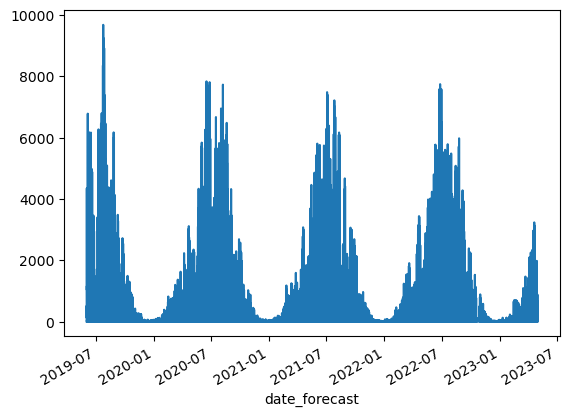

In [145]:
train['effectivehum'] = (train['absolute_humidity_2mgm3']) * (train['direct_radW'])

test['effectivehum'] = (test['absolute_humidity_2mgm3']) * (test['direct_radW'])
train['effectivehum'].plot()

In [146]:
train['radiation_squared'] = train['clear_sky_radW'] ** 2
test['radiation_squared'] = test['clear_sky_radW'] ** 2


In [147]:
train['direct_radW_squared'] = train['direct_radW'] ** 2
test['direct_radW_squared'] = test['direct_radW'] ** 2
train['direct_diffuse_rad_interaction'] = train['direct_radW'] * train['diffuse_radW']
test['direct_diffuse_rad_interaction'] = test['direct_radW'] * test['diffuse_radW']
train['weather_condition'] = train['pressure_100mhPa'] * train['air_density_2mkgm3'] / train['ceiling_height_aglm']
test['weather_condition'] = test['pressure_100mhPa'] * test['air_density_2mkgm3'] / test['ceiling_height_aglm']
train['humidity_ratio'] = train['absolute_humidity_2mgm3'] / (train['relative_humidity_1000hPap'] + 1e-5)
test['humidity_ratio'] = test['absolute_humidity_2mgm3'] / (test['relative_humidity_1000hPap'] + 1e-5)


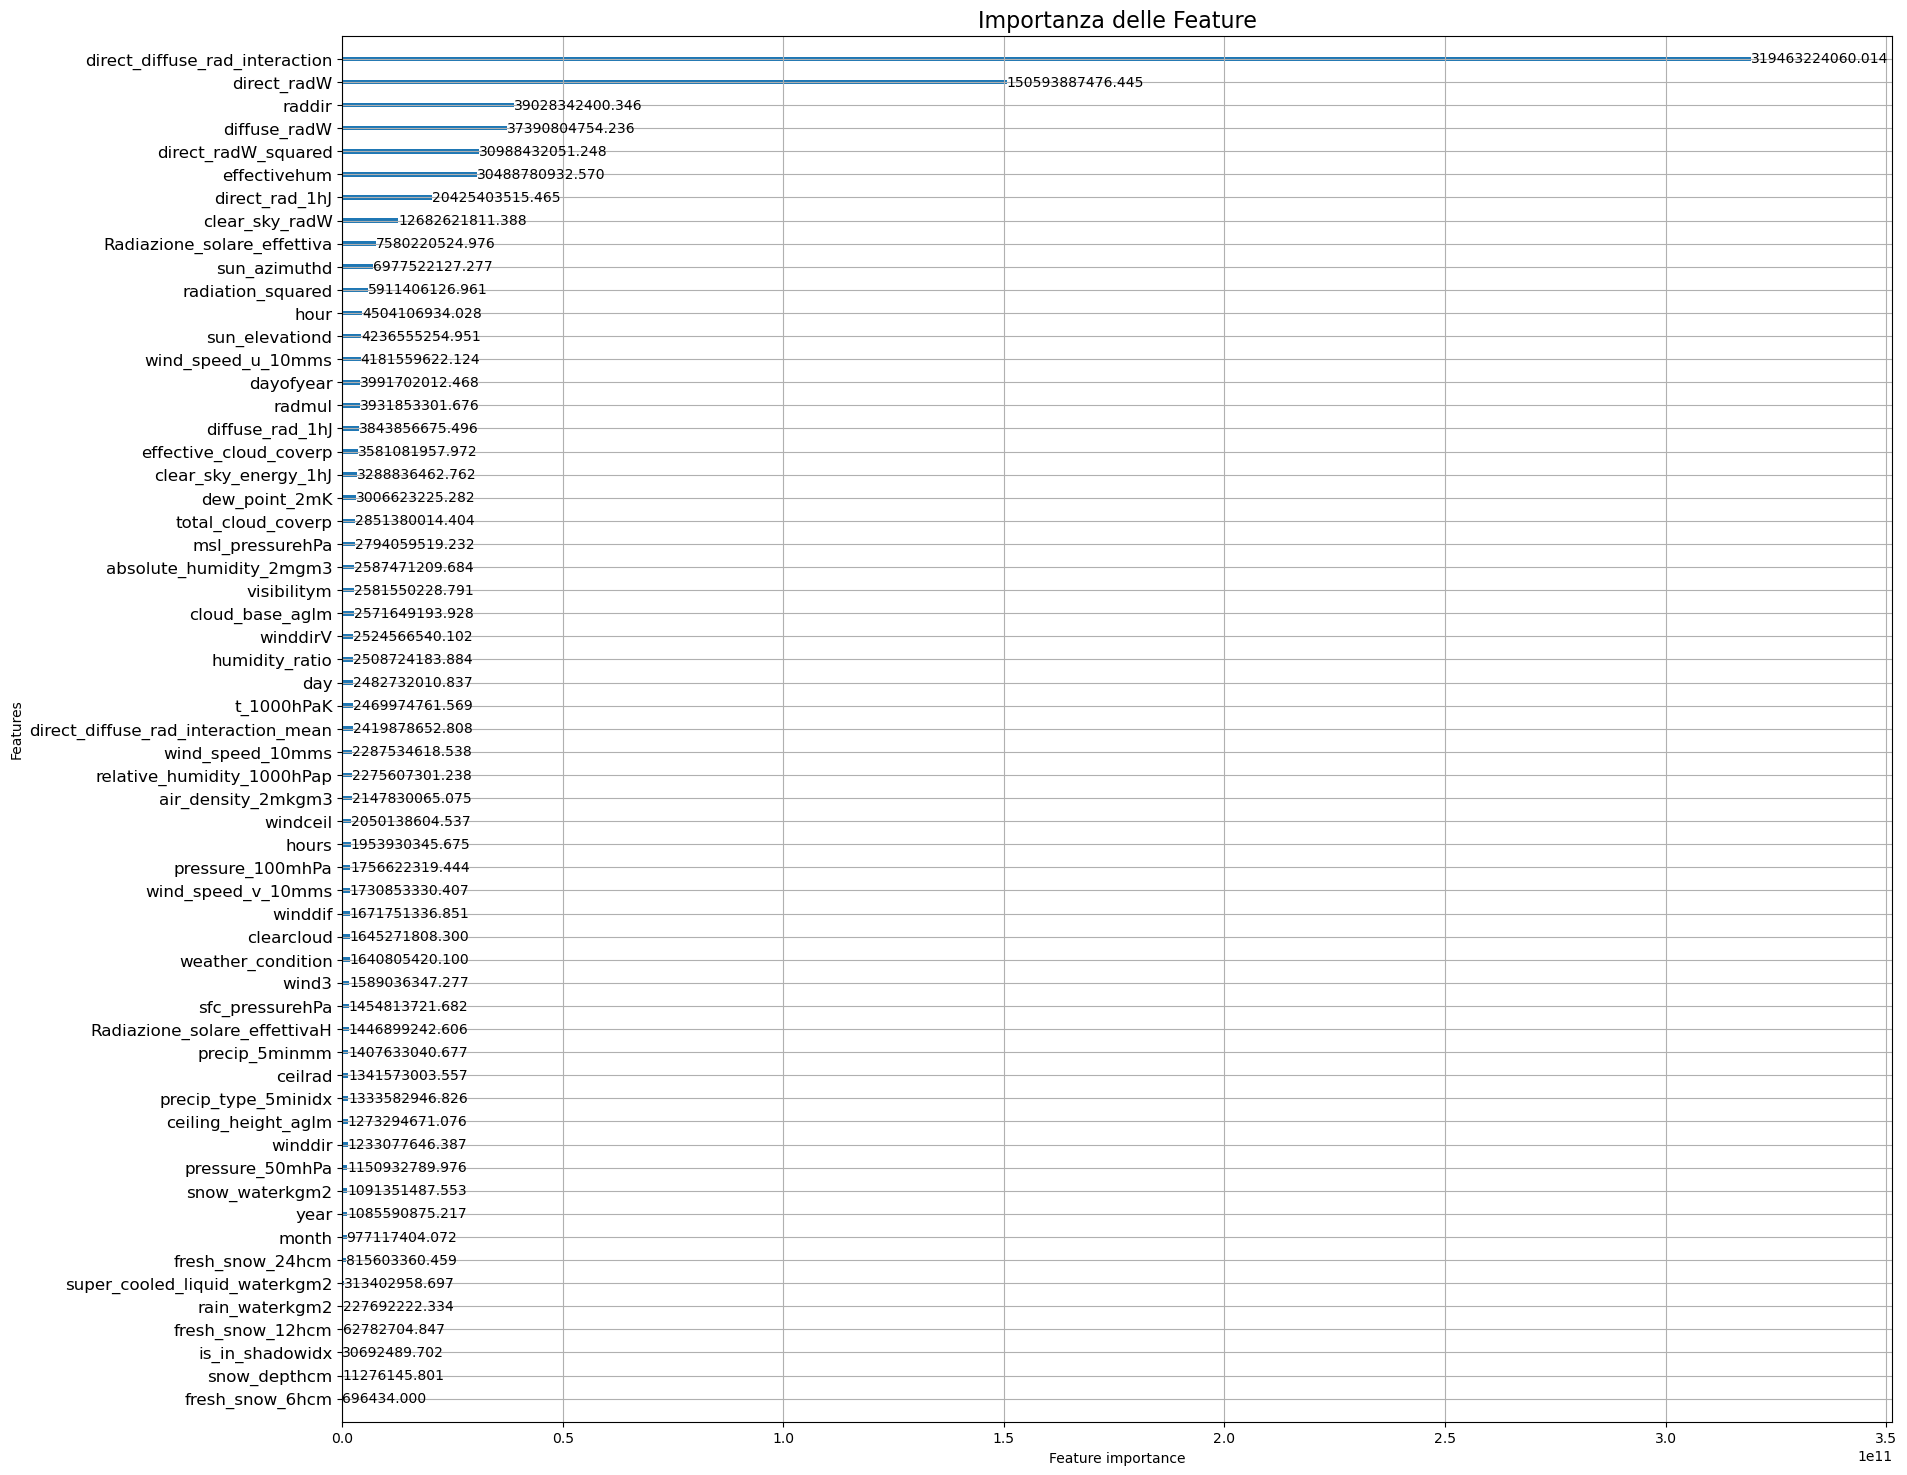

In [148]:
lgb.plot_importance(model_A, importance_type='gain', figsize=(20, 18))

# Aggiungi un'etichetta al grafico
plt.title("Importanza delle Feature", fontsize=16)

# Regola la dimensione dei tick sull'asse y
plt.yticks(fontsize=12)

# Mostra il grafico
plt.show()